# PySpark + MongoDB for spectroscopy-based plastic classification

Make sure to install the correct versions of pyspark, python and mongodb connector:
~~~
    conda create -n sparkenv python=3.9
    pip install pyspark==3.2.0
    pip install mongo-spark-connector
~~~

Also make sure to use java version 11, use the following commands on Linux to find and change your installed java jdk's:
~~~
update-java-alternatives --list
sudo update-java-alternatives --set java-1.11.0-openjdk-amd64
~~~

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, udf 
from pyspark.sql.types import ArrayType, FloatType,
from pyspark.ml.functions import array_to_vector
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import os 
from dotenv import load_dotenv 
load_dotenv() # load credentials

True

In [7]:
CONN_STRING = os.getenv('CONN_STRING')
my_spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.read.connection.uri", CONN_STRING) \
    .config("spark.mongodb.write.connection.uri", CONN_STRING) \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector:10.0.3") \
    .config("spark.driver.memory", '8g') \
    .getOrCreate()

24/04/23 23:27:14 WARN Utils: Your hostname, tom-desktop resolves to a loopback address: 127.0.1.1; using 192.168.1.197 instead (on interface eno1)
24/04/23 23:27:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/tom/.ivy2/cache
The jars for the packages stored in: /home/tom/.ivy2/jars
org.mongodb.spark#mongo-spark-connector added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8638d58a-4259-4933-b02a-1fb1749b3312;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/tom/anaconda3/envs/sparkenv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector;10.0.3 in central
	found org.mongodb#mongodb-driver-sync;4.5.1 in central
	[4.5.1] org.mongodb#mongodb-driver-sync;[4.5.0,4.5.99)
	found org.mongodb#bson;4.5.1 in central
	found org.mongodb#mongodb-driver-core;4.5.1 in central
:: resolution report :: resolve 1952ms :: artifacts dl 4ms
	:: modules in use:
	org.mongodb#bson;4.5.1 from central in [default]
	org.mongodb#mongodb-driver-core;4.5.1 from central in [default]
	org.mongodb#mongodb-driver-sync;4.5.1 from central in [default]
	org.mongodb.spark#mongo-spark-connector;10.0.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   4   |   1   |   0   |   0   ||   4   |   0   |
	-------------------------------------

In [30]:
df = (my_spark.read
      .format("mongodb")
      .option("database", "recyclear")
      .option("collection", "recyclear")
      .option("sampleSize", 100)
      .option('uri', CONN_STRING)
      .load())
df.cache() # cache the dataframe since we will be using it a lot

DataFrame[MIRspec_data: array<string>, NIRspec_data: array<string>, RCspec_data: array<string>, _id: string, collectionDate: string, flag: boolean, labels: array<string>, location: string, meta_data: struct<citation:string,color:string,data measured [ISO8601]:string,description:string,file Revision:string,file multi:string,group internal:string,hierarchy1:string,hierarchy2:string,hierarchy3:string,hierarchy4:string,instrument:string,private label/file name:string,type:string,wavenumber:string>, plasticNum: string]

In [9]:
df.printSchema()

root
 |-- MIRspec_data: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NIRspec_data: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- RCspec_data: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- _id: string (nullable = true)
 |-- collectionDate: string (nullable = true)
 |-- flag: boolean (nullable = true)
 |-- labels: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- location: string (nullable = true)
 |-- meta_data: struct (nullable = true)
 |    |-- citation: string (nullable = true)
 |    |-- color: string (nullable = true)
 |    |-- data measured [ISO8601]: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- file Revision: string (nullable = true)
 |    |-- file multi: string (nullable = true)
 |    |-- group internal: string (nullable = true)
 |    |-- hierarchy1: string (nullable = true)
 |    |-- hierarchy2: string (nullable = true)
 |

Our training data consists of both a set of 'Virgin' materials, which have the location='V' tag, and materials that we collected on 02-08-2023 and on 09-08-2023 at ECOWERF, which we labelled using a labo spectrometer (MIRspec_data).

In [31]:
df = df.filter((col('collectionDate') == '09-08-2023') | (col('collectionDate') == '02-08-2023') | (col('location') == 'V'))
df.show(1)

+--------------------+------------+--------------------+--------------------+--------------+-----+--------------------+--------+--------------------+----------+
|        MIRspec_data|NIRspec_data|         RCspec_data|                 _id|collectionDate| flag|              labels|location|           meta_data|plasticNum|
+--------------------+------------+--------------------+--------------------+--------------+-----+--------------------+--------+--------------------+----------+
|[[2499.0191349895...|        null|[[883.2443, 887.3...|64dcf97d03a2a04b7...|    02-08-2023|false|[PP, PP, PP, PP, ...|       E|{null, null, null...|         7|
+--------------------+------------+--------------------+--------------------+--------------+-----+--------------------+--------+--------------------+----------+
only showing top 1 row



The labels are in the 'hierarchy4' field of the meta data:

In [32]:
LABELS_TO_USE = ['PP', 'HDPE', 'PVC', 'PC', 'ABS', 'PS']
df = df.withColumn('ys',col('meta_data.hierarchy4'))
df = df.filter(col("ys").isin(LABELS_TO_USE))

And our spectra are in RCspec_data, which is a matrix where the first row consists of the wavelenghts (x-axis) and the other rows are spectroscopy measurements of the object. For our ML algorithms, we will average those measurements since they are highly correlated.

In [33]:
df = df.select('RCspec_data', 'ys') # drop the columns we don't need
df = df.filter(col('RCspec_data').isNotNull()) # drop rows containg Nulls
df = df.withColumn('parsed_features', from_json(col('RCspec_data').cast('string'), schema=ArrayType(ArrayType(FloatType())))) # parse the spectra
df = df.drop('RCspec_data') # drop the unparsed spectra
df.show(5)

+---+--------------------+
| ys|     parsed_features|
+---+--------------------+
| PP|[[883.2443, 887.3...|
| PC|[[883.2443, 887.3...|
| PP|[[883.2443, 887.3...|
| PC|[[883.2443, 887.3...|
| PC|[[883.2443, 887.3...|
+---+--------------------+
only showing top 5 rows



We use a UDF to take the average of the spectra across the first dimension

In [34]:
import pandas as pd
import numpy as np

@udf(returnType=ArrayType(FloatType()))
def myudf(spectra):
    if spectra is None or type(spectra) != list:
        return None 
    nparr = np.array(spectra, dtype=np.float32)
    if len(nparr.shape) == 2:
        result = np.mean(nparr[1:, 52:231], axis=0)
        result = (result - np.mean(result)) / np.std(result)
        return result.tolist()
    return None

In [35]:
df = df.withColumn('features', myudf(col('parsed_features')))
df = df.drop('parsed_features') # we don't need the parsed features anymore

In [39]:
df.filter(col('parsed_features').isNull()).count() # make sure features are properly parsed

0

In [40]:
df = df.withColumn("X", array_to_vector(col("features"))) # transform to vector format for pyspark.ml
df = df.drop("features")

Let's look at the distribution of the labels before applying ML:

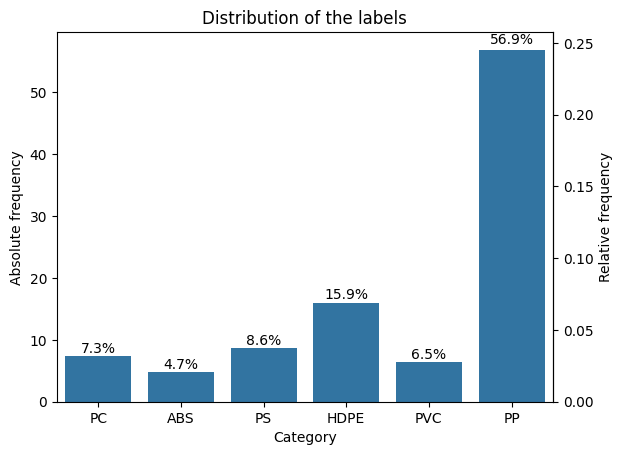

In [54]:
# Use seaborn for plotting the bar chart
import seaborn as sns
import matplotlib.pyplot as plt 

category_counts = df.groupBy("ys").count()
category_counts_pd = category_counts.toPandas()
total_count = category_counts_pd['count'].sum()
category_counts_pd['relative_frequency'] = category_counts_pd['count'] / total_count * 100

ax = sns.barplot(x="ys", y="relative_frequency", data=category_counts_pd)
fun = lambda x: x / total_count
inv = lambda x: x * total_count
ax2 = ax.secondary_yaxis("right", functions=(fun, inv))
ax2.set_ylabel('Relative frequency')
ax.set_xlabel("Category")
ax.set_ylabel("Absolute frequency")
for i, v in enumerate(category_counts_pd['relative_frequency']):
    ax.text(i, category_counts_pd['count'][i]/2.3, f'{v:.1f}%', ha='center', va='bottom', fontsize=10)
plt.title("Distribution of the labels")
plt.show()


The dataset is highly unbalanced and we should therefore use a metric such as the f1 score that accounts for this. A lower bound for accuracy is already 56.9%.

## Let's train a logistic regression model on this dataset

In [60]:
trainDF, testDF = df.randomSplit([.8, .2], seed=41) # create train, and test split

In [61]:
lr = LogisticRegression(featuresCol="X", labelCol="Y")
stringIndexer = StringIndexer(inputCol='ys', outputCol='Y', handleInvalid='skip') # the pyspark.ml.LogisticRegression expects floats as labels
pipeline = Pipeline(stages=[stringIndexer, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction",
    labelCol="Y",
    metricName="accuracy"
)
acc = evaluator.evaluate(predDF)
evaluator.setMetricName('f1')
f1 = evaluator.evaluate(predDF)
print('Mean accuracy: ', acc)
print("Mean f1 score: ", f1)

Mean accuracy:  1.0
Mean f1 score:  1.0
